### Gap Junction API

In [88]:
import sys
sys.path.insert(0, '/home/tommytang111/gap-junction-segmentation/code/src')
from pathlib import Path
import os
import re
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
    BinaryJaccardIndex
)
from torchvision.transforms.functional import to_tensor
from scipy.ndimage import label

#Custom libraries
from utils import *
from models import TestDataset, UNet

#### Functions

In [2]:
def filter_pixels(img) -> np.ndarray:
    """
    Changes all non-zero pixel islands in an image to zero if they are less than 8 pixels in size. Designed for greyscale images.
    """
    # Create a copy to avoid modifying the original during iteration
    filtered = img.copy()
    # Label connected components (8-connectivity)
    structure = np.ones((3, 3), dtype=int)
    labeled, num_features = label(img > 0, structure=structure)
    # For each pixel, check if its component has at least 8 pixels
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] != 0:
                component_label = labeled[y, x]
                if component_label == 0:
                    filtered[y, x] = 0
                    continue
                # Count pixels in this component
                count = np.sum(labeled == component_label)
                if count < 8:
                    filtered[y, x] = 0
    return filtered

def check_directory(path: str) -> None:
    """
    Clear a directory if it exists, and create it if it doesn't.
    """
    if os.path.exists(path):
        subprocess.run(f"rm -f {path}/*", shell=True)
    else:
        os.makedirs(path)

#### Preprocess Data - Get Tiles From Full Section

In [ ]:
!python3 main_processing.py \
  --preprocessing \
  --make_twoD \
  --imgs_dir "/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_full/s110-119" \
  --seg_dir "/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_full/s110-119" \
  --output_dir "/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s110-119" 

Relevant Preprocessing Arguments:
Image Directory: /home/tommytang111/data/sem_dauer_2/SEM_full/s110-119
Image Template: SEM_dauer_2_em_
Segmentation Directory: /home/tommytang111/data/sem_dauer_2/segmentations_full/s110-119
Segmentation Template: sem_dauer_2_gj_gt_
Testing mode: False
Output Directory for 2d Dataset: /home/tommytang111/data/sem_dauer_2/SEM_split/s110-119
Requested Output Image Size: 512
Create Overlap: False
Segmentation Ignore: [2, 15]
NOTE: Unreported arguments were ignored.
100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


In [3]:
#Important Paths
section_of_interest = "s000-050_filtered" #Section of interest, usually 10 slices
model_dir = "/home/tommytang111/gap-junction-segmentation/models/unet_base_516imgs_sem_adult_ak5v2m7m.pt" #Model
dataset_dir = os.path.join("/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split", section_of_interest) #Data
output_dir = os.path.join("/home/tommytang111/gap-junction-segmentation/outputs/inference_results/sem_dauer_2", section_of_interest) #Output for inference

#Data and Labels (sorted because naming convention is typically dataset, section, coordinates. Example: SEM_Dauer_2_image_export_s000 -> 001)
imgs = [i for i in sorted(os.listdir(os.path.join(dataset_dir, "imgs")))] 
labels = [i for i in sorted(os.listdir(os.path.join(dataset_dir, "gts")))]

#### Load data (Either from split sections or another source)

In [4]:
#Create TestDataset class (Note:There are other dataset types in datasets.py). This defines how images/data is read from disk.
dataset = TestDataset(dataset_dir, td=False, membrane=False)
#Load dataset class in Dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)

#### Load model

In [5]:
#model = joblib.load(model_dir)
model = UNet()
model.load_state_dict(torch.load(model_dir))
model = model.to("cuda") #Send to gpu
model.eval() #Set evaluation mode

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (dropout): Dropout(p=0, inplace=False)
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (projection_add): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (final): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (dropout): Dropout(p=0, inplace=False)
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

#### Inference

In [6]:
"""
Generates gap junction prediction masks for each batch, converting each tensor into a numpy array with cpu as uint8. 
Keeps track of the image number while going through batches, assuming the data is sorted by alphabetically ascending 
order when read from disk. 
"""
#NOTE: I SHOULD NORMALIZE THE IMAGES BEFORE PASSING THEM TO THE MODEL

check_directory(output_dir)

img_num = 0 #References which image is being refered to in imgs:List

with torch.no_grad(): 
    for batch in tqdm(dataloader):
        image = batch[0].to("cuda")
        batch_pred = model(image)
        for i in range(batch_pred.shape[0]): #For each image in the batch
            #Convert tensor to binary mask using Sigmoid activation first
            gj_pred = (nn.Sigmoid()(batch_pred[i]) >= 0.5)
            gj_pred = gj_pred.squeeze(0).detach().cpu().numpy().astype("uint8")
            save_name = Path(output_dir) / re.sub(r'.png$', r'_pred.png', imgs[img_num])
            cv2.imwrite(save_name, gj_pred * 255) #All values either black:0 or white:255
            img_num += 1

100%|██████████| 65/65 [00:13<00:00,  4.84it/s]


#### Visualize Results

Showing: /home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s000-050_filtered/imgs/SEM_dauer_2_image_export_s024_Y12_X9.png


<Figure size 1500x500 with 0 Axes>

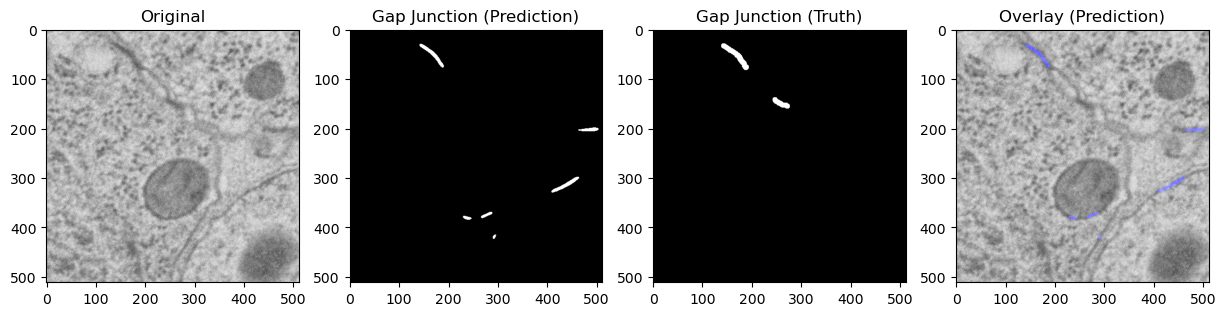

In [7]:
#Test a random image from the dataset
random_path = random.choice(imgs)
random_img = Path(dataset_dir) / "imgs" / random_path
random_gts = cv2.imread(Path(dataset_dir) / "gts" / re.sub(r'.png$', r'_label.png', str(random_path)))
random_gts[random_gts > 0] = 255
random_resized_img = np.array(resize_image(str(random_img), 512, 512, (0,0,0), channels=True))
random_pred = cv2.imread(str(Path(output_dir) / re.sub(r'.png$', r'_pred.png', str(random_path))), cv2.IMREAD_GRAYSCALE)

#Make overlay
random_pred2 = cv2.cvtColor(random_pred, cv2.COLOR_GRAY2RGB)
random_pred2[random_pred == 255] = [0, 0, 255] #Blue
overlay = cv2.addWeighted(random_resized_img, 1, random_pred2, 1, 0)

#Plot
plt.figure(figsize=(15,5))
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(cv2.imread(random_img), cmap="gray")
ax[0].set_title('Original')
#ax[1].imshow(random_resized_img, cmap="gray")
#ax[1].set_title('Cropped/Paded')
ax[1].imshow(random_pred, cmap="gray")
ax[1].set_title('Gap Junction (Prediction)')
ax[2].imshow(random_gts, cmap="gray")
ax[2].set_title('Gap Junction (Truth)')
ax[3].imshow(overlay)
ax[3].set_title('Overlay (Prediction)')
#plt.savefig('/home/tommytang111/gap-junction-segmentation/Figures/unet_base_pooled_2695imgs_sem_dauer_2_516imgs_sem_adult_3wgoc5hr.png', bbox_inches='tight', dpi=300)
print(f"Showing: {random_img}")

Showing: /home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s000-050_filtered/imgs/SEM_dauer_2_image_export_s012_Y11_X11.png


<Figure size 1500x500 with 0 Axes>

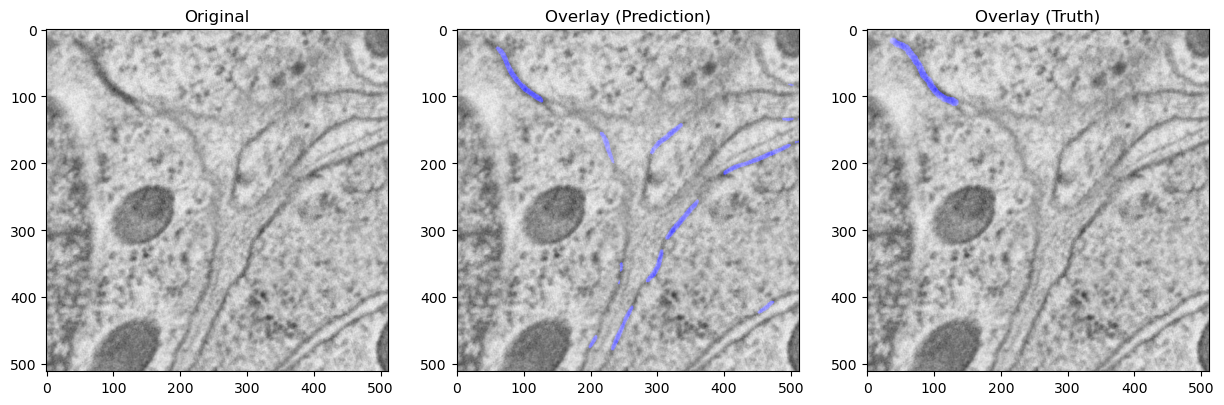

In [15]:
#Another variant of the above code, but with a different plot style
#Test a random image from the dataset
random_path = random.choice(imgs)
random_img = Path(dataset_dir) / "imgs" / random_path
random_gts = cv2.imread(Path(dataset_dir) / "gts" / re.sub(r'.png$', r'_label.png', str(random_path)), cv2.IMREAD_GRAYSCALE)
random_gts[random_gts > 0] = 255
random_resized_img = np.array(resize_image(str(random_img), 512, 512, (0,0,0), channels=True))
random_pred = cv2.imread(str(Path(output_dir) / re.sub(r'.png$', r'_pred.png', str(random_path))), cv2.IMREAD_GRAYSCALE)

#Make overlays
random_pred2 = cv2.cvtColor(random_pred, cv2.COLOR_GRAY2RGB)
random_pred2[random_pred == 255] = [0, 0, 255] #Blue
overlay1 = cv2.addWeighted(random_resized_img, 1, random_pred2, 1, 0)
random_gts2 = cv2.cvtColor(random_gts, cv2.COLOR_GRAY2RGB)
random_gts2[random_gts == 255] = [0, 0, 255] #Blue
overlay2 = cv2.addWeighted(random_resized_img, 1, random_gts2, 1, 0)

#Plot
plt.figure(figsize=(15,5))
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(cv2.imread(random_img), cmap="gray")
ax[0].set_title('Original')
#ax[1].imshow(random_resized_img, cmap="gray")
#ax[1].set_title('Cropped/Paded')
ax[1].imshow(overlay1)
ax[1].set_title('Overlay (Prediction)')
ax[2].imshow(overlay2)
ax[2].set_title('Overlay (Truth)')
#plt.savefig('/home/tommytang111/gap-junction-segmentation/Figures/unet_base_pooled_2695imgs_sem_dauer_2_516imgs_sem_adult_3wgoc5hr.png', bbox_inches='tight', dpi=300)
print(f"Showing: {random_img}")

#### Post-Inference Evaluation

#### Method 1: GPU (2X Faster)

In [11]:
#Create results dictionary
results = {'accuracy': [],
           'precision': [],
           'recall': [],
           'f1': [],
           'iou': [],
           'dice': []
}

In [12]:
# Initialize metrics on GPU for speed
device = torch.device('cuda')
metrics = {
    'accuracy': BinaryAccuracy().to(device),
    'precision': BinaryPrecision().to(device),
    'recall': BinaryRecall().to(device),
    'f1': BinaryF1Score().to(device),
    'iou': BinaryJaccardIndex().to(device)
}

all_preds = []
all_labels = []

# First collect all predictions and labels
for img in tqdm(imgs):
    # Load prediction
    gj_pred = Path(output_dir) / re.sub(r'.png$', r'_pred.png', img)
    gj_pred = cv2.imread(str(gj_pred), cv2.IMREAD_GRAYSCALE)
    
    # Load label
    gj_label = Path(dataset_dir) / "gts" / re.sub(r'.png$', r'_label.png', img)
    gj_label = cv2.imread(str(gj_label), cv2.IMREAD_GRAYSCALE)
    gj_label[gj_label != 0] = 255  # Convert 1s to 255 if they aren't already 255
    gj_label = filter_pixels(gj_label)  # Filter out potential errors

    # Ensure same dimensions
    if gj_pred.shape != gj_label.shape:
        gj_pred = cv2.resize(gj_pred, (gj_label.shape[1], gj_label.shape[0]))

    # Binarize as boolean masks
    gj_pred_binary = (gj_pred > 127).astype(np.uint8)
    gj_label_binary = (gj_label > 128).astype(np.uint8)
    
    # Convert to tensors
    gj_pred_tensor = torch.from_numpy(gj_pred_binary).float()
    gj_label_tensor = torch.from_numpy(gj_label_binary).float()

    all_preds.append(gj_pred_tensor)
    all_labels.append(gj_label_tensor)

with torch.no_grad():
    # Stack all images into a single batch if they're the same size
    if all(p.shape == all_preds[0].shape for p in all_preds):
        pred_batch = torch.stack(all_preds).to(device)
        label_batch = torch.stack(all_labels).to(device)
        
        # Calculate metrics in one go
        for metric_name, metric_fn in metrics.items():
            results[metric_name] = metric_fn(pred_batch, label_batch).item()
        
        # Calculate Dice score from IoU (they're related)
        results['dice'] = 2 * results['iou'] / (1 + results['iou'])
    else:
        # If images have different sizes, process one by one but still use GPU
        for metric_name, metric_fn in metrics.items():
            metric_fn.reset()
            
        for pred, Label in zip(all_preds, all_labels):
            pred = pred.unsqueeze(0).to(device)  # Add batch dimension
            Label = Label.unsqueeze(0).to(device)
            
            for metric_name, metric_fn in metrics.items():
                metric_fn.update(pred, Label)

        # Compute final metrics
        for metric_name, metric_fn in metrics.items():
            results[metric_name] = metric_fn.compute().item()
        
        # Calculate Dice score
        results['dice'] = 2 * results['iou'] / (1 + results['iou'])

# Print results
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")

100%|██████████| 516/516 [01:53<00:00,  4.55it/s]


accuracy: 0.9920
precision: 0.4393
recall: 0.5223
f1: 0.4772
iou: 0.3134
dice: 0.4772


#### Method 2: CPU (default and recommended)

In [61]:
#We have a list of all the input image file names in imgs
for img in tqdm(imgs):
    #Load Predictions
    gj_pred = Path(output_dir) / re.sub(r'.png$', r'_pred.png', img)
    gj_pred = cv2.imread(gj_pred, cv2.IMREAD_GRAYSCALE)

    #Load labels
    gj_label = Path(dataset_dir) / 'gts' / re.sub(r'.png$', r'_label.png', img)
    gj_label = cv2.imread(gj_label, cv2.IMREAD_GRAYSCALE)
    gj_label[gj_label != 0] = 255  # Convert 1s to 255 if they aren't already 255
    gj_label = filter_pixels(gj_label)  # Filter out potential errors
    
    #Ensure same dimensions
    if gj_pred.shape != gj_label.shape:
        gj_pred = cv2.resize(gj_pred, (gj_pred.shape[1], gj_pred.shape[0]))
        
    #Binarize masks (0 or 1)
    gj_pred_binary = (gj_pred > 127).astype(np.uint8)
    gj_label_binary = (gj_label > 128).astype(np.uint8)
    
    #Flatten masks for metric calculations
    gj_pred_flat = gj_pred_binary.flatten()
    gj_label_flat = gj_label_binary.flatten()
    
    #Calculate metrics
    cm = confusion_matrix(gj_label_flat, gj_pred_flat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel() #Extract from confusion matrix
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    dice = (2 * iou) / (1 + iou)
    
    #Append to results
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['iou'].append(iou)
    results['dice'].append(dice)

    """Another way but slower
    results['accuracy'].append(accuracy_score(gj_label_flat, gj_pred_flat))
    results['precision'].append(precision_score(gj_label_flat, gj_pred_flat, zero_division=0))
    results['recall'].append(recall_score(gj_label_flat, gj_pred_flat, zero_division=0))
    results['f1'].append(f1_score(gj_label_flat, gj_pred_flat, zero_division=0))
    results['iou'].append(jaccard_score(gj_label_flat, gj_pred_flat, zero_division=0))
    
    #Calculate Dice Manually
    intersection = np.logical_and(gj_pred_binary, gj_label_binary).sum()
    dice = (2.0 * intersection) / (gj_pred_binary.sum() + gj_label_binary.sum() + 1e-10)
    results['dice'].append(dice)"""
    
#Calculate averages
for key in results:
    results[key] = np.mean(results[key])

print(results)

100%|██████████| 40/40 [00:45<00:00,  1.15s/it]

{'accuracy': np.float64(0.9709577560424805), 'precision': np.float64(0.5587510934383186), 'recall': np.float64(0.5830541970520596), 'f1': np.float64(0.5565330902934089), 'iou': np.float64(0.4039114945047662), 'dice': np.float64(0.5565330950680311)}


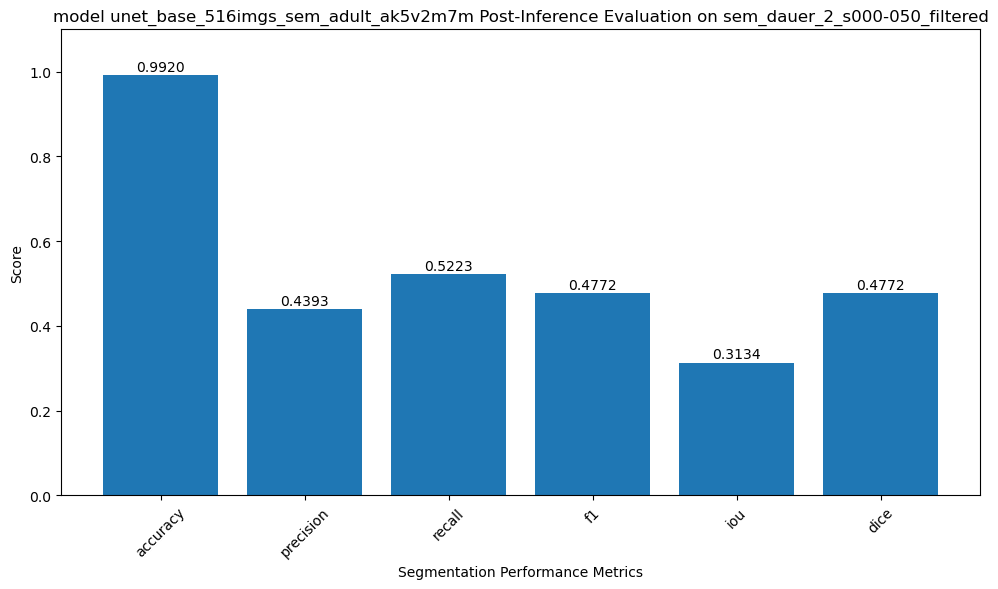

In [13]:
#Plot bar chart of evaluation results
plt.figure(figsize=(10,6))
plt.title('model unet_base_516imgs_sem_adult_ak5v2m7m Post-Inference Evaluation on sem_dauer_2_s000-050_filtered')
plt.bar(results.keys(), results.values())
plt.ylim(0,1.1)
plt.xlabel('Segmentation Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()
